##Team Name:
### Made Oka Resia Wedamerta (m.wedamerta@innopolis.university)
### Mahmoud Mousatat (m.mousatat@innopolis.university)

# Fake News Detection

## Motivation using TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) is a commonly used technique in natural language processing for representing text data as a vector of numerical features. TF-IDF is good for fake news detection because it can capture the important words and phrases that distinguish fake news from real news.

TF-IDF works by assigning a weight to each word in a document based on its frequency in the document and its frequency in the corpus (collection of documents). Words that appear frequently in a document but rarely in the corpus are considered important and are assigned a high weight, while words that appear frequently in both the document and the corpus are considered less important and are assigned a low weight. This approach helps to identify words and phrases that are unique to a document and are therefore good indicators of its content.

In the context of fake news detection, TF-IDF can be used to represent each news article as a vector of numerical features that capture the important words and phrases in the article. This vector can then be used as input to a machine learning algorithm for classification. By comparing the TF-IDF vectors of different news articles, we can identify the words and phrases that are most characteristic of fake news and use them to train a model to distinguish fake news from real news.

Overall, TF-IDF is a powerful technique for analyzing text data and has been shown to be effective for fake news detection. However, it is important to note that TF-IDF alone may not be sufficient for detecting all instances of fake news, and additional features and techniques may be needed to improve the accuracy of the model.

## Implementation TF-IDF

In [ ]:
# Import relevant packages and modules
from csv import DictReader
from csv import DictWriter
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf


# Initialise global variables
label_ref = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}
label_ref_rev = {0: 'agree', 1: 'disagree', 2: 'discuss', 3: 'unrelated'}
stop_words = [
        "a", "about", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along",
        "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
        "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as", "at", "back", "be",
        "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
        "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom", "but", "by", "call", "can", "co",
        "con", "could", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight",
        "either", "eleven", "else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
        "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill", "find", "fire", "first", "five", "for",
        "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had",
        "has", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself",
        "him", "himself", "his", "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed", "interest",
        "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made",
        "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much",
        "must", "my", "myself", "name", "namely", "neither", "nevertheless", "next", "nine", "nobody", "now", "nowhere",
        "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours",
        "ourselves", "out", "over", "own", "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see",
        "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some",
        "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take",
        "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby",
        "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though",
        "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve",
        "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what",
        "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon",
        "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will",
        "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves"
        ]


# Define data class
class FNCData:

    """

    Define class for Fake News Challenge data

    """

    def __init__(self, file_instances, file_bodies):

        # Load data
        self.instances = self.read(file_instances)
        bodies = self.read(file_bodies)
        self.heads = {}
        self.bodies = {}

        # Process instances
        for instance in self.instances:
            if instance['Headline'] not in self.heads:
                head_id = len(self.heads)
                self.heads[instance['Headline']] = head_id
            instance['Body ID'] = int(instance['Body ID'])

        # Process bodies
        for body in bodies:
            self.bodies[int(body['Body ID'])] = body['articleBody']

    def read(self, filename):

        """
        Read Fake News Challenge data from CSV file

        Args:
            filename: str, filename + extension

        Returns:
            rows: list, of dict per instance

        """

        # Initialise
        rows = []

        # Process file
        with open(filename, "r", encoding='utf-8') as table:
            r = DictReader(table)
            for line in r:
                rows.append(line)

        return rows


# Define relevant functions
def pipeline_train(train, test, lim_unigram):

    """

    Process train set, create relevant vectorizers

    Args:
        train: FNCData object, train set
        test: FNCData object, test set
        lim_unigram: int, number of most frequent words to consider

    Returns:
        train_set: list, of numpy arrays
        train_stances: list, of ints
        bow_vectorizer: sklearn CountVectorizer
        tfreq_vectorizer: sklearn TfidfTransformer(use_idf=False)
        tfidf_vectorizer: sklearn TfidfVectorizer()

    """

    # Initialise
    heads = []
    heads_track = {}
    bodies = []
    bodies_track = {}
    body_ids = []
    id_ref = {}
    train_set = []
    train_stances = []
    cos_track = {}
    test_heads = []
    test_heads_track = {}
    test_bodies = []
    test_bodies_track = {}
    test_body_ids = []
    head_tfidf_track = {}
    body_tfidf_track = {}

    # Identify unique heads and bodies
    for instance in train.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        if head not in heads_track:
            heads.append(head)
            heads_track[head] = 1
        if body_id not in bodies_track:
            bodies.append(train.bodies[body_id])
            bodies_track[body_id] = 1
            body_ids.append(body_id)

    for instance in test.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        if head not in test_heads_track:
            test_heads.append(head)
            test_heads_track[head] = 1
        if body_id not in test_bodies_track:
            test_bodies.append(test.bodies[body_id])
            test_bodies_track[body_id] = 1
            test_body_ids.append(body_id)

    # Create reference dictionary
    for i, elem in enumerate(heads + body_ids):
        id_ref[elem] = i

    # Create vectorizers and BOW and TF arrays for train set
    bow_vectorizer = CountVectorizer(max_features=lim_unigram, stop_words=stop_words)
    bow = bow_vectorizer.fit_transform(heads + bodies)  # Train set only

    tfreq_vectorizer = TfidfTransformer(use_idf=False).fit(bow)
    tfreq = tfreq_vectorizer.transform(bow).toarray()  # Train set only

    tfidf_vectorizer = TfidfVectorizer(max_features=lim_unigram, stop_words=stop_words).\
        fit(heads + bodies + test_heads + test_bodies)  # Train and test sets

    # Process train set
    for instance in train.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        head_tf = tfreq[id_ref[head]].reshape(1, -1)
        body_tf = tfreq[id_ref[body_id]].reshape(1, -1)
        if head not in head_tfidf_track:
            head_tfidf = tfidf_vectorizer.transform([head]).toarray()
            head_tfidf_track[head] = head_tfidf
        else:
            head_tfidf = head_tfidf_track[head]
        if body_id not in body_tfidf_track:
            body_tfidf = tfidf_vectorizer.transform([train.bodies[body_id]]).toarray()
            body_tfidf_track[body_id] = body_tfidf
        else:
            body_tfidf = body_tfidf_track[body_id]
        if (head, body_id) not in cos_track:
            tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
            cos_track[(head, body_id)] = tfidf_cos
        else:
            tfidf_cos = cos_track[(head, body_id)]
        feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
        train_set.append(feat_vec)
        train_stances.append(label_ref[instance['Stance']])

    return train_set, train_stances, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer


def pipeline_test(test, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer):

    """

    Process test set

    Args:
        test: FNCData object, test set
        bow_vectorizer: sklearn CountVectorizer
        tfreq_vectorizer: sklearn TfidfTransformer(use_idf=False)
        tfidf_vectorizer: sklearn TfidfVectorizer()

    Returns:
        test_set: list, of numpy arrays

    """

    # Initialise
    test_set = []
    heads_track = {}
    bodies_track = {}
    cos_track = {}

    # Process test set
    for instance in test.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        if head not in heads_track:
            head_bow = bow_vectorizer.transform([head]).toarray()
            head_tf = tfreq_vectorizer.transform(head_bow).toarray()[0].reshape(1, -1)
            head_tfidf = tfidf_vectorizer.transform([head]).toarray().reshape(1, -1)
            heads_track[head] = (head_tf, head_tfidf)
        else:
            head_tf = heads_track[head][0]
            head_tfidf = heads_track[head][1]
        if body_id not in bodies_track:
            body_bow = bow_vectorizer.transform([test.bodies[body_id]]).toarray()
            body_tf = tfreq_vectorizer.transform(body_bow).toarray()[0].reshape(1, -1)
            body_tfidf = tfidf_vectorizer.transform([test.bodies[body_id]]).toarray().reshape(1, -1)
            bodies_track[body_id] = (body_tf, body_tfidf)
        else:
            body_tf = bodies_track[body_id][0]
            body_tfidf = bodies_track[body_id][1]
        if (head, body_id) not in cos_track:
            tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
            cos_track[(head, body_id)] = tfidf_cos
        else:
            tfidf_cos = cos_track[(head, body_id)]
        feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
        test_set.append(feat_vec)

    return test_set


def load_model(sess):

    """

    Load TensorFlow model

    Args:
        sess: TensorFlow session

    """

    saver = tf.train.Saver()
    saver.restore(sess, './model/model.checkpoint')


def save_predictions(pred, file):

    """

    Save predictions to CSV file

    Args:
        pred: numpy array, of numeric predictions
        file: str, filename + extension

    """

    with open(file, 'w') as csvfile:
        fieldnames = ['Stance']
        writer = DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for instance in pred:
            writer.writerow({'Stance': label_ref_rev[instance]})

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import relevant packages and modules
#from util import *
import random
#import tensorflow as tf
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# Set file names
file_train_instances = "train_stances.csv"
file_train_bodies = "train_bodies.csv"
file_test_instances = "test_stances_unlabeled.csv"
file_test_bodies = "test_bodies.csv"
file_predictions = 'predictions_test.csv'


# Initialise hyperparameters
r = random.Random()
lim_unigram = 5000
target_size = 4
hidden_size = 100
train_keep_prob = 0.6
l2_alpha = 0.00001
learn_rate = 0.01
clip_ratio = 5
batch_size_train = 500
epochs = 90


# Load data sets
raw_train = FNCData(file_train_instances, file_train_bodies)
raw_test = FNCData(file_test_instances, file_test_bodies)
n_train = len(raw_train.instances)

# Process data sets
train_set, train_stances, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer = \
    pipeline_train(raw_train, raw_test, lim_unigram=lim_unigram)
feature_size = len(train_set[0])
test_set = pipeline_test(raw_test, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer)

In [ ]:
# Define model

# Create placeholders
features_pl = tf.compat.v1.placeholder(tf.float32, [None, feature_size], 'features')
stances_pl = tf.compat.v1.placeholder(tf.int64, [None], 'stances')
keep_prob_pl = tf.compat.v1.placeholder(tf.float32)

# Infer batch size
batch_size = tf.shape(features_pl)[0]

# Define multi-layer perceptron
hidden_layer = tf.keras.layers.Dropout(rate=1-keep_prob_pl)(
               tf.keras.layers.Dense(units=hidden_size, activation='relu')(features_pl))
logits_flat = tf.keras.layers.Dropout(rate=1-keep_prob_pl)(
              tf.keras.layers.Dense(units=target_size)(hidden_layer))
logits = tf.reshape(logits_flat, [batch_size, target_size])

# Define L2 loss
tf_vars = tf.compat.v1.trainable_variables()
l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in tf_vars if 'bias' not in v.name]) * l2_alpha

# Define overall loss
loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=stances_pl) + l2_loss)

# Define prediction
softmaxed_logits = tf.nn.softmax(logits)
predict = tf.argmax(softmaxed_logits, axis=1)


# Define optimiser
opt_func = tf.optimizers.Adam(learn_rate)
grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tf_vars), clip_ratio)
opt_op = opt_func.apply_gradients(zip(grads, tf_vars))

# Perform training
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())

    for epoch in range(epochs):
        total_loss = 0
        indices = list(range(n_train))
        r.shuffle(indices)

        for i in range(n_train // batch_size_train):
            batch_indices = indices[i * batch_size_train: (i + 1) * batch_size_train]
            batch_features = [train_set[i] for i in batch_indices]
            batch_stances = [train_stances[i] for i in batch_indices]

            batch_feed_dict = {features_pl: batch_features, stances_pl: batch_stances, keep_prob_pl: train_keep_prob}
            _, current_loss = sess.run([opt_op, loss], feed_dict=batch_feed_dict)
            total_loss += current_loss


    # Predict
    test_feed_dict = {features_pl: test_set, keep_prob_pl: 1.0}
    test_pred = sess.run(predict, feed_dict=test_feed_dict)

# Save predictions
save_predictions(test_pred, file_predictions)

{<tf.Tensor 'features:0' shape=(None, 10001) dtype=float32>: [array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.01101397]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.05492823]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.58884009]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.16965133]), array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.02539352]), array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.31066443]), array([0.        , 0.        , 0.     

In [ ]:
#for loop for getting first key
for new_s, new_val in test_feed_dict.items():
#print first key
    print(new_s[100])
#after getting first key break loop
    break

Tensor("strided_slice_1:0", shape=(10001,), dtype=float32)


In [ ]:
with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        test_pscore = sess.run(softmaxed_logits, feed_dict=test_feed_dict)



In [ ]:
for i in range(10):print(test_pred[i],test_pscore[i])

0 [0.2520224  0.24894506 0.24975081 0.24928176]
3 [0.24844219 0.24279252 0.25437978 0.2543855 ]
0 [0.2575163  0.24448375 0.25269586 0.24530405]
2 [0.24764878 0.24762788 0.25366843 0.25105494]
2 [0.24863455 0.24191777 0.26017186 0.2492758 ]
2 [0.25406218 0.24059764 0.25410044 0.25123972]
1 [0.25122237 0.2533599  0.2501127  0.24530502]
2 [0.25414005 0.24479373 0.25605902 0.24500719]
2 [0.24949111 0.2455555  0.25270513 0.2522483 ]
2 [0.24834642 0.2485668  0.25177938 0.25130737]


In [ ]:
from sklearn.metrics import accuracy_score
import pandas as pd

y_pred = pd.read_csv("predictions_test.csv")
y_pred = y_pred['Stance']

y_true = pd.read_csv("true_test_stances.csv")
y_true = y_true['Stance']

print(y_true, y_pred)
accuracy_score(y_true, y_pred)

0        unrelated
1        unrelated
2        unrelated
3        unrelated
4        unrelated
           ...    
25408        agree
25409      discuss
25410     disagree
25411     disagree
25412        agree
Name: Stance, Length: 25413, dtype: object 0            agree
1        unrelated
2            agree
3          discuss
4          discuss
           ...    
25408    unrelated
25409    unrelated
25410      discuss
25411    unrelated
25412      discuss
Name: Stance, Length: 25413, dtype: object


0.26281824263172393

## BERT Implementation

BERT is a advanced pre-trained word embedding model based on transformer encoded architecture. We utilize BERT as a sentence encoder, which can accurately get the context representation of a sentence. BERT removes the unidirectional constraint using a mask language model (MLM). It randomly masks some of the tokens from the input and predicts the original vocabulary id of the masked word based only. MLM has increased the capability of BERT to outperforms as compared to previous embedding methods. It is a deeply bidirectional system that is capable of handling the unlabelled text by jointly conditioning on both left and right context in all layers. In this research, we have extracted embeddings for a sentence or a set of words or pooling the sequence of hidden-states for the whole input sequence. A deep bidirectional model is more powerful than a shallow left-to-right and right-to-left model.

In [ ]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 36.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score


In [ ]:
# Load the data into a Pandas dataframe.
df_content = pd.read_csv('train_bodies.csv')
df_headline = pd.read_csv('train_stances.csv')


In [ ]:
df = pd.merge(df_content, df_headline, on="Body ID")

In [ ]:
df

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated
...,...,...,...,...
49967,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",agree
49968,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",agree
49969,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",agree
49970,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,agree


In [ ]:
feature = df[['articleBody', 'Headline']]
feature

,articleBody,Headline
0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun..."
1,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...
2,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...
3,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa
4,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...
...,...,...
49967,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00..."
49968,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip"
49969,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip"
49970,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...


In [ ]:
data_classes = ["unrelated", "discuss","disagree","agree"]
label = df['Stance'].apply(data_classes.index)

In [ ]:
# Split the data into train and test sets.
train_text, test_text, train_labels, test_labels = train_test_split(feature, label, test_size=0.2, random_state=42)

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize the text inputs.
train_tokens = tokenizer.batch_encode_plus(
    train_text.values.tolist(),
    max_length = 512,
    padding=True,
    truncation=True
)

test_tokens = tokenizer.batch_encode_plus(
    test_text.values.tolist(),
    max_length = 512,
    padding=True,
    truncation=True
)

# Convert the tokenized inputs to PyTorch tensors.
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
test_y = torch.tensor(test_labels.values.tolist())

# Create a DataLoader for our training set.
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=16)

# Create a DataLoader for our test set.
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=16)


In [ ]:
# Load the pre-trained BERT model for sequence classification.
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False
)

# Define the optimizer and learning rate scheduler.
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
!nvidia-smi

Fri Mar 31 17:43:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Set the model to the device (GPU or CPU).
model.to(device)

# Train the model.
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)
    
    # Set the model to training mode.
    model.train()
    
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Unpack the batch.
        batch_seq, batch_mask, batch_y = batch
        
        # Set the batch to the device.
        batch_seq = batch_seq.to(device)
        batch_mask = batch_mask.to(device)
        batch_y = batch_y.to(device)
        
        # Zero out any gradients.
        model.zero_grad()
        
        # Perform a forward pass.
        outputs = model(batch_seq, attention_mask=batch_mask, labels=batch_y)
        loss = outputs[0]
        total_loss += loss.item()
        
        # Perform a backward pass and optimize.
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
    # Calculate the average loss for this epoch.
    avg_loss = total_loss / len(train_dataloader)
    print('Average loss: {:.2f}'.format(avg_loss))




Epoch 1/5
----------
Average loss: 0.27

Epoch 2/5
----------
Average loss: 0.11

Epoch 3/5
----------
Average loss: 0.05

Epoch 4/5
----------
Average loss: 0.03

Epoch 5/5
----------
Average loss: 0.01


In [ ]:
model.save_pretrained('pretrained_model/')

In [ ]:
#Finally, we'll evaluate the model on the test set:

# Set the model to evaluation mode.
model.eval()

# Create lists to store the predictions and true labels.
preds = []
true_labels = []

# Evaluate the model on the test set.
for batch in test_dataloader:
    # Unpack the batch.
    batch_seq, batch_mask, batch_y = batch
    
    # Set the batch to the device.
    batch_seq = batch_seq.to(device)
    batch_mask = batch_mask.to(device)
    batch_y = batch_y.to(device)
    
    # Disable gradient calculations.
    with torch.no_grad():
        # Perform a forward pass.
        outputs = model(batch_seq, attention_mask=batch_mask)
        logits = outputs[0]
        probs = torch.softmax(logits, dim=1)
        preds.extend(torch.argmax(probs, dim=1).tolist())
        true_labels.extend(batch_y.tolist())

# Calculate the F1 score and accuracy on the test set.
f1 = f1_score(true_labels, preds, average='weighted')
acc = accuracy_score(true_labels, preds)

print('F1 score: {:.2f}'.format(f1))
print('Accuracy: {:.2f}'.format(acc))


F1 score: 0.99
Accuracy: 0.99


##Implementation of deep learning model

This model's design was chosen because it is simple to use and allows for quick calculation since convolutions may be used in place of recurrence. Convolutions appear to be able to capture a wide range of themes, based on the relative strength of this model; however, the model is constrained in that it only gets to view the text once. Adding an attention mechanism with recurrence after the convolutions, which would enable the model to query specific elements of the headline/body after getting a broad summary from CNN, might be a viable enhancement to this model.


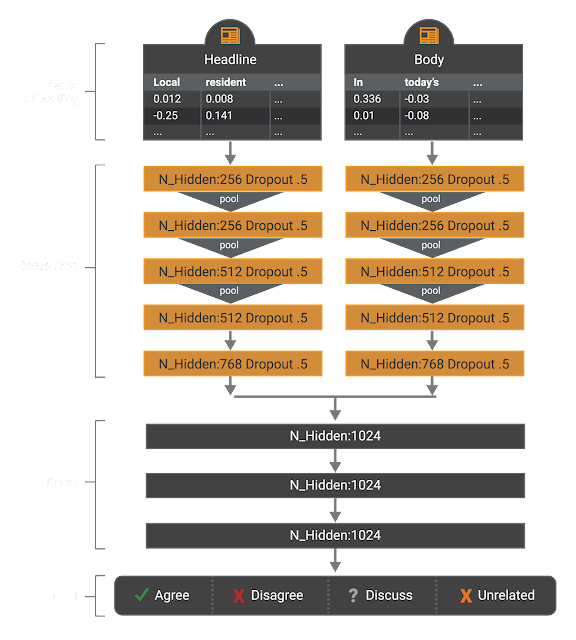

CNNS ENABLE EFFICIENT, EFFECTIVE PARALLEL COMPUTATION WHILE PERFORMING THIS CNN'S OUTPUT IS THEN SENT TO AN MULTI-LAYER PERCEPTRON (MLP) WITH 4-CLASS OUTPUT — "AGREE," "DISAGREE," "DISCUSS," AND "UNRELATED" — AND TRAINED END-TO-END. ALL CONVOLUTIONAL LAYERS USED DROPOUT (P=.5) TO REGULARIZE THE MODEL. Nevertheless, none of the model's hyperparameters were further evaluated to identify better options; instead, they were all set to sensible defaults.

In [ ]:
import time
from collections import defaultdict

import numpy as np
import theano
import theano.tensor as T
import theano.d3viz as d3v
import theano.gpuarray
from theano.sandbox.rng_mrg import MRG_RandomStreams as RNG




def max_over_time(out):
    m = out.max(axis=-1)
    return m.reshape((m.shape[0], m.shape[1]))

class Conv1(object):
    #object wrapping for 1 dimensional convolution
    #input shape: (batch_size, n_in, 1, sequence_length)

    def __init__(self, n_in=1, n_out=1, width=1, pad=1, stride=1, dilate=1, act=T.nnet.relu):
        v = 2./float(n_in*width)
        fshape = (n_out, n_in, 1, width)
        wv = np.random.normal(0, v, fshape).astype('float32')
        bv = np.zeros(n_out).astype('float32')
        #xavier init

        w = theano.shared(wv)
        b = theano.shared(bv)
        self.w =w
        self.b =b
        self.params = [w,b]
        #setup theano vars and params

        self.act = act
        self.pad = pad
        self.stride=stride
        self.dilate=dilate
        #store anything needed for conv2d

    def __call__(self, inp):
        conv_out = conv2d(inp, self.w, subsample=(1,self.stride), border_mode=(0,self.pad), filter_dilation=(1,self.dilate))+self.b.dimshuffle('x',0,'x','x')
        #convolution + bias linear output

        act = self.act
        if act == T.nnet.relu:
            return T.nnet.relu(conv_out,.1)
        #apply non-linearity and return
        return act(conv_out)

class Conv1_Drop(object):

    def __init__(self, n_in=1, n_out=1, width=1, pad=1, stride=1, act=T.nnet.relu,rng=None,drop_prob=.5):
        v = 2./float(n_in*width)
        fshape = (n_out, n_in, 1, width)
        wv = np.random.normal(0, v, fshape).astype('float32')
        bv = np.zeros(n_out).astype('float32')

        w = theano.shared(wv)
        b = theano.shared(bv)
        self.w =w
        self.b =b
        self.params = [w,b]
        self.act = act
        self.pad = pad
        self.stride=stride
        if rng is None:
            self.rng = RNG()
        else:
            self.rng = rng
        self.drop_prob = drop_prob

        global drop_flag
        self.drop_flag = drop_flag

    def __call__(self, inp):
        conv_out = dnn_conv(inp, self.w, subsample=(1,self.stride), border_mode=(0,self.pad))+self.b.dimshuffle('x',0,'x','x')

        act = self.act
        if act == T.nnet.relu:
            nonlin = T.nnet.relu(conv_out,.1)
        nonlin = act(conv_out)

        drop_mask = self.rng.binomial(n=1, p=self.drop_prob, size=nonlin.shape)
        nonlin_drop = nonlin* T.cast(drop_mask,'float32')/self.drop_prob

        nonlin_out = T.switch(T.eq(self.drop_flag,1), nonlin_drop, nonlin)
        return nonlin_out

class Pool1(object):
    #object wrapping for 1 dimensional pooling
    #input shape: (batch_size, n_in, 1, sequence_length)
    def __init__(self, size=2):
        self.size=size

    def __call__(self, inp):
        return dnn_pool(inp, (1,self.size), (1,self.size))
        # return T.signal.pool.pool_2d(inp, (1,self.size))

def dense(inp, n_in,n_out, act=T.nnet.relu):
    #simple dense layer

    v = 2./float(n_in*n_out)
    w_v = np.random.normal(0,v,(n_in,n_out)).astype('float32')
    b_v = np.zeros(n_out).astype('float32')
    #xavier init

    w = theano.shared(w_v)
    b = theano.shared(b_v)
    lin = T.dot(inp,w)+b
    #set up theano vars, get linear output

    if act==T.nnet.relu:
        print ("RELU, MANUAL LRELU")
        return T.nnet.relu(lin, .1), w,b
    elif act is None:
        return lin, w, b
    #apply non-linearity and return with params
    return act(lin), w, b

class GradClip(theano.compile.ViewOp):
  #gradient clipping between a range
    def __init__(self, clip_lower_bound, clip_upper_bound):
        self.clip_lower_bound = clip_lower_bound
        self.clip_upper_bound = clip_upper_bound
        assert(self.clip_upper_bound >= self.clip_lower_bound)

    def grad(self, args, g_outs):
        return [T.clip(g_out, self.clip_lower_bound, self.clip_upper_bound) for g_out in g_outs]

def Adam(grads, params, lr=0.0002, b1=0.1, b2=0.001, e=1e-8):
    #https://arxiv.org/abs/1412.6980
    updates = []
    i = theano.shared(np.float32(0.))
    i_t = i + 1.
    fix1 = 1. - (1. - b1)**i_t
    fix2 = 1. - (1. - b2)**i_t
    lr_t = lr * (T.sqrt(fix2) / fix1)
    for p, g in zip(params, grads):
        m = theano.shared(p.get_value() * 0.)
        v = theano.shared(p.get_value() * 0.)
        m_t = (b1 * g) + ((1. - b1) * m)
        v_t = (b2 * T.sqr(g)) + ((1. - b2) * v)
        g_t = m_t / (T.sqrt(v_t) + e)
        p_t = p - (lr_t * g_t)
        updates.append((m, m_t))
        updates.append((v, v_t))
        updates.append((p, p_t))
    updates.append((i, i_t))
    return updates


def Train(cost=None, params=None, inputs=None, outputs=None, rho=.9, givens={}, clip=False, updates={},learning_rate=.9, profile=False):
    #helper function to produce a theano training function, wrapping most of the boilerplate stuff
    if clip:
        grad_clip = GradClip(-clip,clip)
        grads = T.grad(grad_clip(cost),params)
    else:
        grads = T.grad(cost, params)
        grad_updates = Adam(grads, params)

        for u in updates:
            print (u, updates[u])
            if isinstance(grad_updates, list):
                grad_updates.append((u, updates[u]))
            else:
                grad_updates[u] = updates[u]


    print ('Build train ',)
    t0 = time.time()
    train_model = theano.function(inputs=inputs, outputs=outputs, updates=grad_updates, givens=givens, on_unused_input='warn', profile=profile)
    print (time.time() - t0)
    return train_model

def score(pred, act):
    s = 0
    if pred == act == 3:
        s+=.25
    if act != 3 and pred != 3:
        s+=.25
    if pred == act != 3:
        s+=.75
    return s

if __name__ == '__main__':
    theano.gpuarray.use('cuda1')
    v = GoogleVec()
    v.load()

    np.random.seed(2)


    n_chars = len(chars)+1
    n_classes = 4
    #static values

    n_hidden = 256
    emb_dim = 300
    #variable network hyperparameters


    body_chars = T.imatrix()
    head_chars = T.imatrix()
    target = T.ivector()
    drop_flag = T.iscalar()
    #set up symbolic inputs
    #all inputs are int



    emb_mat = v.shared()
    #get the word vector embedding matrix as a theano.shared



    head_tensor = emb_mat[head_chars].dimshuffle(0,2,'x',1)
    body_tensor = emb_mat[body_chars].dimshuffle(0,2,'x',1)
    #convert matrix of ints into tensor4 of float32s
    #character ints are indices
    #output shape (batch_size, emb_dim, 1, sequence_length)

    c0 = Conv1_Drop(n_in=emb_dim, n_out=n_hidden, width=3,pad=3)
    c1 = Conv1_Drop(n_in=n_hidden, n_out=n_hidden, width=3,pad=3)
    c2 = Conv1_Drop(n_in=n_hidden, n_out=n_hidden*2, width=3,pad=3)
    c3 = Conv1_Drop(n_in=n_hidden*2, n_out=n_hidden*2, width=3,pad=1)
    c4 = Conv1_Drop(n_in=n_hidden*2, n_out=n_hidden*3, width=3,pad=1)
    #1d conv layers, all with width=3, hidden size increases with depth
    p0 = Pool1()
    p1 = Pool1()
    p2 = Pool1()
    #a couple pooling layers

    c0_o = c0(body_tensor)
    p0_o = p0(c0_o)
    c1_o = c1(p0_o)
    p1_o = p1(c1_o)
    c2_o = c2(p1_o)
    p2_o = p2(c2_o)
    c3_o = c3(p2_o)
    body_conv = c4(c3_o)
    #run the bodies through all conv ops

    c0_o = c0(head_tensor)
    p0_o = p0(c0_o)
    c1_o = c1(p0_o)
    p1_o = p1(c1_o)
    c2_o = c2(p1_o)
    p2_o = p2(c2_o)
    c3_o = c3(p2_o)
    head_conv = c4(c3_o)
    #run the heads through all conv ops


    head_vec = max_over_time(head_conv)
    body_vec = max_over_time(body_conv)
    #head/body_conv still variable length, take max feature value to get fixed-length vector


    feature_vec = T.concatenate([head_vec, body_vec],axis=1)
    #join head/body features

    d0, w0, b0 = dense(feature_vec, n_in=n_hidden*3*2, n_out=n_hidden*4)
    d1, w1, b1 = dense(d0, n_in=n_hidden*4, n_out=n_hidden*4)
    d2, w2, b2 = dense(d1, n_in=n_hidden*4, n_out=n_hidden*4)
    s0, ws, bs = dense(d2, n_in=n_hidden*4, n_out=n_classes, act=T.nnet.softmax)
    #create fully-connected relu net
    #output is softmax since problem is multi-class but not multi-label

    pred = T.argmax(s0,axis=1)
    err = T.neq(pred,target.flatten()).mean()
    #predictions/error rate

    cost = T.nnet.categorical_crossentropy(s0, target).mean()
    #correct cross_entropy for softmax

    params = [w0,b0,w1,b1,w2,b2,ws,bs]+c0.params+c1.params+c2.params+c3.params+c4.params
    #collect all parameters to learn via gradient descent



    news = News(stances='train.csv', bodies='train_bodies.csv', vecs=v)
    #FNC Baseline training set
    val_news = News(stances='test.csv', bodies='train_bodies.csv', vecs=v)
    #FNC baseline validation set
    test_news = News(stances='test_stances_unlabeled.csv', vecs=v, bodies='test_bodies.csv')
    #FNC final test set


    test = theano.function([head_chars, body_chars, target], pred, on_unused_input='ignore', givens={drop_flag:np.int32(0)})
    probs = theano.function([head_chars, body_chars, target], s0, on_unused_input='ignore', givens={drop_flag:np.int32(0)})
    #compile function that just returns predictions
    train = Train(cost=cost, params=params, inputs=[head_chars, body_chars, target], outputs=cost, profile=False, givens={drop_flag:np.int32(1)})
    #compile function that returns cost term and performs 1 step of gradient descent


    costs = []
    right = defaultdict(int)
    wrong = defaultdict(int)
    t0 = time.time()
    n = 32
    eval_test = True
    output_fn = 'deepoutput.csv'

    if eval_test:
        with open('params_final.p','r') as f:
            params1=pickle.load(f)
        for o,n in zip(params, params1):
            assert o.get_value().shape == n.get_value().shape
            o.set_value(n.get_value())
        #extremely simple model persistance, pickle our list of params
        #if we attempt to load weights that don't match the shape, make some noise

        with open(output_fn,'w') as f:
            writer = csv.writer(f)
            writer.writerow(['Headline','BodyID','Agree', 'Disagree','Discuss','Unrelated'])
            #set up our csv
            i = 0
            for head,body,stance in test_news.validate():
                #iterate through the test_news set and output probabilities to csv
                t = []
                h,b,s = test_news.headlines[i]
                t.append(h)
                t.append(b)
                sp = probs(head,body,stance)
                #tmp.append(sp[0])
                t.extend(sp[0])
                writer.writerow(t)

                i+=1
                if i%50==0:
                    print (i)
        exit()

    best_score = 0
    #simple training loop, draw n samples and perform 1 GD update
    #every so often print stats/save params
    for i in xrange(35000000):

        head,body, stance = news.sample(n=n)
        try:
            #Catch OOM/small size problems and just continue
            c = train(head, body, stance)
            costs.append(c)
        except:
            pass


        if i%500==0:
            print (i, np.mean(costs), time.time() - t0)
            t0 = time.time()
            costs = []

        if i%5000==0 and i>10:
            #every 5000 steps, check against the validation set
            #if we have a new high score, save the params
            m = 0
            b = 0
            print( i, time.time() - t0)
            for head,body,stance in val_news.validate():
                preds = test(head, body, stance)
                for p, a in zip(preds, stance):

                    m+= score(p, a)
                    b+= score(a, a)

                    if p == a:
                        right[p]+=1
                    else:
                        wrong[p]+=1

            print (m, b)
            print (' ')
            t0 = time.time()
            if m>best_score:
                print ('SAVED ---------------------------',m)
                best_score = m
                with open('params.p','wb') as f:
                   pickle.dump(params, f)

            right = defaultdict(int)
            wrong = defaultdict(int)



In [ ]:
import csv

import pickle
import gzip
from time import time

import numpy as np
import theano
import theano.tensor as T

try:
	from theano.sandbox.cuda.dnn import dnn_conv, dnn_pool
except:
	from theano.gpuarray.dnn import dnn_conv, dnn_pool


from theano.tensor.nnet import conv2d


from collections import defaultdict


from Vectors import *



chars = set([chr(i) for i in range(32,128)])
#character whitelist
stances = {'agree':0,'disagree':1,'discuss':2,'unrelated':3}
#set up some values for later


def transform(text):
    #convert a string into a np array of approved character indices, starting at 0
    return np.array([ord(i)-32 for i in text if i in chars])

def pad_char(text, padc=-1):
    #take a set of variable length arrays and convert to a matrix with specified fill value
    maxlen = max([len(i) for i in text])
    tmp = np.ones((len(text), maxlen),dtype='int32')
    tmp.fill(padc)
    for i in range(len(text)):
        data = text[i]
        tmp[i,:len(data)]=data
    return tmp



def split():
    #split data into train/test, not used
    train = []
    test = []
    with open('train_ids.txt','r') as f:
        train_sets = set([int(i.strip()) for i in f.readlines()])
    with open('test_ids.txt','r') as f:
        test_sets = set([int(i.strip()) for i in f.readlines()])
    print( len(train_sets), len(test_sets))
    with open('train_stances.csv','r') as f:
        reader = csv.reader(f)
        reader.next()
        for l in reader:

            if int(l[1]) in train_sets:

                train.append(l)
            else:
                test.append(l)

    print (len(train), len(test))

    for dat, fn in zip([train, test],['train.csv','test.csv']):
        with open(fn,'wb') as f:
            writer = csv.writer(f)
            writer.writerow(['header'])
            for l in dat:
                writer.writerow(l)

def proc_bodies(fn):
    #process the bodies csv into arrays
    tmp = {}
    with open(fn,'r') as f:
        reader = csv.reader(f)
        reader.next()
        for line in reader:
            bid, text = line
            tmp[bid]=text
    return tmp

class News(object):
    #object for processing and presenting news to clf

    def __init__(self, stances='train_stances.csv',bodies='train_bodies.csv',vecs=None):
        #process files into arrays, etc
        self.bodies = proc_bodies(bodies)
        self.headlines = []
        self.vecs=vecs

        with open(stances,'r') as f:
            reader = csv.reader(f)
            reader.next()
            for line in reader:
                if len(line)==2:
                    hl, bid = line
                    stance = 'unrelated'
                else:
                    hl, bid, stance = line
                self.headlines.append((hl,bid,stance))


        self.n_headlines = len(self.headlines)


    def get_one(self, ridx=None):
        #select a single sample either randomly or by index
        if ridx is None:
            ridx = np.random.randint(0,self.n_headlines)
        head = self.headlines[ridx]
        body = self.bodies[head[1]]


        return head, body


    def sample(self, n=16, ridx=None):
        #select a batch of samples either randomly or by index
        heads = []
        bodies = []
        stances_d = []
        if ridx is not None:
            for r in ridx:
                head, body_text = self.get_one(r)
                head_text, _, stance = head
                heads.append(head_text)
                bodies.append(body_text)
                stances_d.append(stances[stance])
        else:
            for i in range(n):
                head, body_text = self.get_one()
                head_text, _, stance = head
                heads.append(head_text)
                bodies.append(body_text)
                stances_d.append(stances[stance])


        heads = self.vecs.transform(heads)
        bodies = self.vecs.transform(bodies)
        stances_d = np.asarray(stances_d, dtype='int32')
        #clean up everything and return it

        return heads, bodies, stances_d


    def validate(self):
        #iterate over the dataset in order
        for i in xrange(len(self.headlines)):
            yield self.sample(ridx=[i])



if __name__ == '__main__':
    v = GoogleVec()

    val_news = News(stances='test_stances_unlabeled.csv', vecs=v, bodies='test_bodies.csv')
    v.load()



In [ ]:
import gensim
import os, string
import time

import numpy as np
import pickle

import theano



def vectorize(text, vocab={}):
    opts = [i for i in text.split(' ') if len(i)>0]

    cidx = 0
    tmp = []
    #iterate over the entire text, construct 3/2 grams first
    while cidx<len(opts):
        c0 = opts[cidx]
        if cidx+1<len(opts):
            c1 = opts[cidx+1]
        else:
            c1 = False
        if cidx+2<len(opts):
            c2 = opts[cidx+2]
        else:
            c2 = False
        if c2:
            s = c0+'_'+c1+'_'+c2
            if s in vocab:
                tmp.append(vocab[s])
                cidx+=3
                continue
        else:
            pass
        if c1:
            s = c0+'_'+c1
            if s in vocab:
                tmp.append(vocab[s])
                cidx+=2
                continue
        else:
            pass
        #no 3/2 grams, check the word
        if c0 in vocab:
            tmp.append(vocab[c0])
        elif c0.lower() in vocab:
            tmp.append(vocab[c0.lower()])
        else:
            #we have no token at this timestep, we could add a default?
            tmp.append(vocab['</s>'])
            pass
        cidx+=1
    return tmp



class GoogleVec(object):
    #logic for loading Google News vectors and transforming strings to word indices

    def __init__(self, path='./GoogleNews-vectors-negative300.bin'):
        self.path = path
        self.model = None
        self.vocab = {}


    def load(self):
        t0 = time.time()
        self.model = gensim.models.KeyedVectors.load_word2vec_format(self.path,unicode_errors='ignore', binary=True)
        print (time.time() - t0)
        for i in range(len(self.model.index2word)):
            self.vocab[self.model.index2word[i]]=i


    #def shared(self):
    #    return theano.shared(self.model.syn0, name='Google Vectors')

    def transform(self, X, pad=0):
        tmp = []
        maxlen=0
        for t in X:
            t = t.translate(None, string.punctuation)
            v = vectorize(t, vocab=self.vocab)
            if len(v)>maxlen:
                maxlen=len(v)
            tmp.append(v)
        e = np.zeros((len(X),maxlen)).astype('int32')
        e.fill(pad)

        for i in range(len(tmp)):
            v = tmp[i]
            e[i,:len(v)]=v
        return e




if __name__ == '__main__':

    gv = GoogleVec()
    gv.load()

    t = ['the quick brown fox jumped over the lazy dog','the. quick, brown! fox,, !']
    print (gv.transform(t))

##The problems we faced till now:

1. Find a good way toc ombining TF-IDF with 1D-CNN so it will give us better result (take the average or use XGB)

#Splitting the work:
Mahmoud Mousatat Work till now:

1. working on the deep learing model  (1D-CNN)

Made Oka Resia Wedamerta work till now:

1. working on the TF-IDF model and  BERT
2. visualize the project using streamlit


# **Third Report**
11/April/2023

**What we aready did in the past few weeks**
1. The TF-IDF code section is completed
2. we found two datasets you will find them on github
3. preprocess the first dataset and apply it on TF-IDF
4. We implemented BERT for our fake news detection, the result is very good in term of accuracy, however it took 5 and half hours to fine-tune the pretrained BERT model
**What we will do in the next few days**
1. Now we are still working on 1D CNN model
2. As the TF-IDF give us not really good performance in term of accuracy, but it work fast, we will try to increase the performance by combine it with our 1D CNN which still in progress
5. visualize what we have done in streamlit
**convert it to product**
1. By making a browser extention which will crawl inside the webpages and get the news and the headline of the news and specifie the label for every post or link or blog inside the webpage.
2. to keep fine tuning the models and keep updating the dataset we gonna use the comment section for every news or blog or post to create the label(target) and add the new news to the dataset with its label
